In [1]:

import src.MCTS as MCTS
from src.Environments import StatelessGym
from src.Experiment import Experiment, RandomExperiment, ParametrizedRandomExperiment
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import median_absolute_error, mean_squared_log_error, max_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance
from sklearn.preprocessing import OneHotEncoder
import ast
import math

def encode_maze(maze):
    num_rows = len(maze)
    num_cols = len(maze[0])

    encoded_maze = []

    for i in range(num_rows):
        for j in range(num_cols):
            if maze[i][j] == 'S':
                encoded_maze.append(0)
            elif maze[i][j] == 'F':
                encoded_maze.append(1)
            elif maze[i][j] == 'H':
                encoded_maze.append(2)
            elif maze[i][j] == 'G':
                encoded_maze.append(3)
            elif maze[i][j] == 'E':
                encoded_maze.append(4)
    return encoded_maze

def add_padding(map, target_size):
    current_size = len(map)
    diff = target_size - current_size
    if diff < 0:
        raise Exception("Current map size is greater than target size")
    elif diff == 0:
        return map
    else:
        result = []
        padding = diff // 2
        left_out = diff % 2
        for i in range(padding):
            result.append('E' * target_size)
        for row in map:
            new_row = 'E' * padding + row + 'E' * padding + 'E' * left_out
            result.append(new_row)
        for i in range(padding + left_out):
            result.append('E' * target_size)
        return result
            

In [2]:
import ast
directory = "../datasets/FrozenLake-v1_m4-4_s1-100_t1/"
dataset_names = os.listdir(directory)
dataset = pd.DataFrame()
print (dataset_names)

for dataset_name in dataset_names:
    dataset = dataset.append(pd.read_csv(directory + dataset_name), ignore_index=True)
    
padding = 4

if 'Map' in dataset.columns:
    if padding > 0: 
        dataset['List_Map'] = dataset['Map'].apply(ast.literal_eval).apply(lambda x: add_padding(x, padding))
    else: 
        dataset['List_Map'] = dataset['Map'].apply(ast.literal_eval)
    #dataset['F_count'] = dataset['Map'].apply(lambda x: sum(row.count('F') for row in x))
    dataset['Encoded_Map'] = dataset['List_Map'].apply(lambda x: encode_maze(x))
print(dataset)
dataset.describe()

['Boosting2_0_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_0_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_10_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_10_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_11_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_11_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_12_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_12_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_13_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_13_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_14_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_14_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_15_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_15_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_16_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_16_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_17_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_17_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_18_15000_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_18_1500_t1_m4-4_FrozenLake-v1.csv', 'Boosting2_19_15000_t1_m4-4_FrozenLake-v1.csv', 'Bo

,Return,Discounted Return
count,1.085247e+06,1.085247e+06
mean,7.978128e-01,7.445142e-01
std,4.016312e-01,3.779050e-01
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,8.201258e-01
50%,1.000000e+00,9.360380e-01
75%,1.000000e+00,9.704018e-01
max,1.000000e+00,9.850897e-01


In [3]:
models = {
    #'LinearRegression': LinearRegression(),
    # #'Ridge': Ridge(alpha=1.0),
    # #'Lasso': Lasso(alpha=1.0),
    # #'ElasticNet':  ElasticNet(alpha=1.0, l1_ratio=0.5),
    #'SVR': SVR(),
    #'DecisionTreeRegressor': DecisionTreeRegressor(),
    #'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, max_depth=10),
    #'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    #'MLPRegressor': MLPRegressor(hidden_layer_sizes=(150, 150, 150), activation='tanh', max_iter=1000000, n_iter_no_change=100, tol=1e-4)
}

## Without Maps

In [33]:
#Getting min and max number of simulations
sim_min = dataset['Simulations'].min()
sim_max = dataset['Simulations'].max()

#Features to be used in the model
features = ['Simulations']

#Folds
fold = 3

train_sizes = list(range(10, 1000, 125)) + list(range(1000, 10000, 1000))
train_scores = []
test_scores = []
for training_set_size in  train_sizes:
    train_scores.append([])
    test_scores.append([])
    
    for i in range(fold):
        #Randomly sampling number of simulations to be included in the test and training set
        test_sims = np.sort(np.random.choice(np.arange(sim_min, sim_max + 1), size=math.ceil((sim_max - sim_min + 1) * 0.33), replace=False))
        #training_sims = np.setdiff1d(np.arange(sim_min, sim_max + 1), test_sims)

        #Creating test set by taking average for test set simulations
        test_set_x = test_sims.reshape(-1, len(features))
        test_set_y = dataset.loc[dataset['Simulations'].isin(test_sims)].groupby(['Simulations']).mean()['Discounted Return'].values
        
        #Creating training set by sampling sim numbers for training set from the remainnig datapoints
        training_set = dataset[dataset['Simulations'].isin(test_sims).apply(lambda x: not x)].sample(n=training_set_size, replace=True)
        
        training_set_x = training_set[features].values.reshape(-1, len(features))
        training_set_y = training_set['Discounted Return'].values
        
        #Creating training score sets
        training_score_set = training_set.groupby(['Simulations']).mean()['Discounted Return']
        training_score_set_x = training_score_set.index.values.reshape(-1, len(features))
        training_score_set_y = training_score_set.values
        
        # print(test_sims)
        # print(training_score_set)
        # print(training_score_set_x.shape)
        # print(training_score_set_y.shape)

        #Training
        for model_name, model in models.items():
            model.fit(training_set_x, training_set_y)
            #Predicting on test set
            y_pred = model.predict(test_set_x)
            #Calculating MSE
            test_score = mean_absolute_error(test_set_y, y_pred)
            test_scores[-1].append(test_score)
            #Predicting on training set
            y_pred = model.predict(training_score_set_x)
            train_score = mean_absolute_error(training_score_set_y, y_pred)
            train_scores[-1].append(train_score)
    print("Training set size: %d\nTraining error: %f\nTest error: %f\n" % (training_set_size, np.mean(train_scores[-1]), np.mean(test_scores[-1])))
        
# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1) / np.sqrt(fold)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1) / np.sqrt(fold)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training error')
plt.plot(train_sizes, test_mean, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
#plt.ylim([0, 1])
plt.show()

print(train_mean)
print(test_mean)

Training set size: 10
Training error: 0.000147
Test error: 0.142854

Training set size: 135
Training error: 0.021588
Test error: 0.113596

Training set size: 260
Training error: 0.027152
Test error: 0.088983

Training set size: 385
Training error: 0.026227
Test error: 0.078574

Training set size: 510
Training error: 0.024422
Test error: 0.070547



KeyboardInterrupt: 

## With Different Maps

In [15]:
training_set_size = 75000

#Unique maps
unique_maps = []
for map in dataset["Map"].unique():
    unique_maps.append(map)
map_count = len(unique_maps)
test_maps = np.random.default_rng().choice(unique_maps, size=500, replace=False)
print("Total unique: ", map_count)

#Creating Test Set
test_set = dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
test_set_x = []
test_set_y = []
for i in range(len(test_set)):
    test_set_x.append([test_set.index[i][1]] + encode_maze(test_set.index[i][0]))
    test_set_y.append(test_set[i])

#Creating Training Set
training_set = dataset[~dataset['Map'].isin(test_maps)]
training_set_sampled = training_set.sample(n=training_set_size, replace=False)
training_set_x = np.append(training_set_sampled["Simulations"].values.reshape(-1, 1), training_set_sampled['Encoded_Map'].apply(pd.Series).values, axis=1)
training_set_y = training_set_sampled["Discounted Return"].values

#Creating Training Score Set
training_score_set = training_set.groupby(["Map", "Simulations"]).mean()["Discounted Return"]
training_score_set_x = []
training_score_set_y = []
for i in range(len(training_score_set)):
    training_score_set_x.append([training_score_set.index[i][1]] + encode_maze(training_score_set.index[i][0]))
    training_score_set_y.append(training_score_set[i])

#Creating Training Score 2 Set - Looking all datapoints in the training sample
training_sampled_unique = training_set_sampled["Map"].unique()
training_score2_set = training_set[training_set["Map"].isin(training_sampled_unique)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
training_score2_set_x = []
training_score2_set_y = []
for i in range(len(training_score2_set)):
    training_score2_set_x.append([training_score2_set.index[i][1]] + encode_maze(training_score2_set.index[i][0]))
    training_score2_set_y.append(training_score2_set[i])


print("Training unique: ", len(training_sampled_unique))
print("Test uniuqe: ", len(test_maps))
print("Missing: ", map_count - len(training_sampled_unique) - len(test_maps))
print("Training score2 set: ", len(training_score2_set))

#test_set.describe()
# print(training_score_set_x)
print(len(test_set_y))

Total unique:  3828
Training unique:  3328
Test uniuqe:  500
Missing:  0
Training score2 set:  945059
31177


In [17]:
print("Missing: ", len(dataset) - len(dataset[dataset['Map'].isin(test_maps)]) - len(training_score2_set))

Missing:  0


In [90]:
#Unique maps
unique_maps = []
for map in dataset["Map"].unique():
    if len(ast.literal_eval(map)) == 7:
        unique_maps.append(map)
map_count = len(unique_maps)
print("Number of unique maps: ", map_count)

Number of unique maps:  29193


Training set size: 10
Training error 1: 0.001172 ± 0.000831
Training error 2: 0.292766 ± 0.045696
Test error: 0.227542 ± 0.009904

Training set size: 135
Training error 1: 0.050712 ± 0.011016
Training error 2: 0.147941 ± 0.014410
Test error: 0.122392 ± 0.004527

Training set size: 260
Training error 1: 0.006914 ± 0.003366
Training error 2: 0.163791 ± 0.009106
Test error: 0.146929 ± 0.012520

Training set size: 385
Training error 1: 0.005796 ± 0.003466
Training error 2: 0.178354 ± 0.016132
Test error: 0.162062 ± 0.017410

Training set size: 510
Training error 1: 0.004795 ± 0.002982
Training error 2: 0.168476 ± 0.007936
Test error: 0.156285 ± 0.007815

Training set size: 635
Training error 1: 0.006063 ± 0.002075
Training error 2: 0.159073 ± 0.002861
Test error: 0.140009 ± 0.002970

Training set size: 760
Training error 1: 0.003723 ± 0.000883
Training error 2: 0.164500 ± 0.010729
Test error: 0.148984 ± 0.005822

Training set size: 885
Training error 1: 0.004016 ± 0.001326
Training error 2

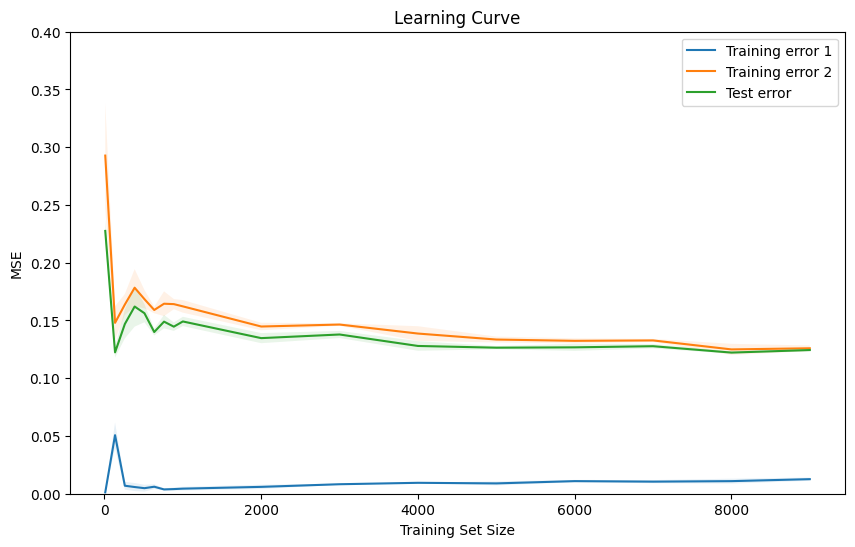

In [10]:
#Getting min and max number of simulations
sim_min = dataset['Simulations'].min()
sim_max = dataset['Simulations'].max()

#Features to be used in the model
features = ['Simulations']

#Unique maps
unique_maps = []
for map in dataset["Map"].unique():
    unique_maps.append(map)
map_count = len(unique_maps)

#Folds
fold = 3

#Test set size
test_set_size = math.ceil((map_count * 0.33))
#test_set_size = len(unique_maps) - 50
#Train set sizes
#train_sizes = [1, 8, 16, 25, 75, 100, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 30000, 60000, 100000, 150000, 200000, 250000, 300000]
train_sizes = train_sizes = list(range(10, 1000, 125)) + list(range(1000, 10000, 1000))
#train_sizes = [1000, 2000, 3000]
#train_sizes = [1, 25, 100]

train_scores1 = []
train_scores2 = []
test_scores = []

for training_set_size in  train_sizes:
    train_scores1.append([])
    train_scores2.append([])
    test_scores.append([])
    
    for i in range(fold):
        #Creating Test Set
        test_maps = np.random.default_rng().choice(unique_maps, size=test_set_size, replace=False)
        test_set = dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        test_set_x = []
        test_set_y = []
        for j in range(len(test_set)):
            test_set_x.append([test_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(test_set.index[j][0]), padding)))
            test_set_y.append(test_set[j])

        #Creating Training Set
        training_set = dataset[~dataset['Map'].isin(test_maps)]
        training_set_sampled = training_set.sample(n=training_set_size, replace=False)
        training_set_x = np.append(training_set_sampled["Simulations"].values.reshape(-1, 1), training_set_sampled['Encoded_Map'].apply(pd.Series).values, axis=1)
        training_set_y = training_set_sampled["Discounted Return"].values

        #print("Maps seen in training: %d" % (len(training_set["Map"].unique())))
        #Creating Training Score 1 Set - Looking only sampled points
        training_score1_set = training_set_sampled.groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score1_set_x = []
        training_score1_set_y = []
        for j in range(len(training_score1_set)):
            training_score1_set_x.append([training_score1_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(training_score1_set.index[j][0]), padding)))
            training_score1_set_y.append(training_score1_set[j])
            
        #Creating Training Score 2 Set - Looking all datapoints in the training sample
        training_sampled_unique = training_set_sampled["Map"].unique()
        training_score2_set = training_set[training_set["Map"].isin(training_sampled_unique)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score2_set_x = []
        training_score2_set_y = []
        for i in range(len(training_score2_set)):
            training_score2_set_x.append([training_score2_set.index[i][1]] + encode_maze(training_score2_set.index[i][0]))
            training_score2_set_y.append(training_score2_set[i])


        # print("train score set info: ")
        # a = (training_set.groupby(["Map", "Simulations"]).std()["Discounted Return"] / (training_set.groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(a.mean())
        # print("test set info: ")
        # b = (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).std()["Discounted Return"] / (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(b.mean())
        #Training
        for model_name, model in models.items():
            model.fit(training_set_x, training_set_y)
            
            #Predicting on test set
            y_pred = model.predict(test_set_x)
            test_score = mean_squared_error(test_set_y, y_pred)
            test_scores[-1].append(test_score)
            
            #Predicting on training score 1 set
            y_pred = model.predict(training_score1_set_x)
            train_score1 = mean_squared_error(training_score1_set_y, y_pred)
            train_scores1[-1].append(train_score1)
            
            #Predicting on training score 2 set
            y_pred = model.predict(training_score2_set_x)
            train_score2 = mean_squared_error(training_score2_set_y, y_pred)
            train_scores2[-1].append(train_score2)
            
        # print("Fold: %d\nTraining set size: %d\nTraining error: %f\nTest error: %f\n" % (i, training_set_size, train_score, test_score))
    print("Training set size: %d\nTraining error 1: %f ± %f\nTraining error 2: %f ± %f\nTest error: %f ± %f\n" % (training_set_size, np.mean(train_scores1[-1]), np.std(train_scores1[-1]), np.mean(train_scores2[-1]), np.std(train_scores2[-1]), np.mean(test_scores[-1]), np.std(test_scores[-1])))
        
# Calculate the mean and standard deviation of the training and test scores
train1_mean = np.mean(train_scores1, axis=1)
train1_std = np.std(train_scores1, axis=1)
train2_mean = np.mean(train_scores2, axis=1)
train2_std = np.std(train_scores2, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train1_mean, label='Training error 1')
plt.plot(train_sizes, train2_mean, label='Training error 2')
plt.plot(train_sizes, test_mean, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([0.0, 0.4])
plt.show()

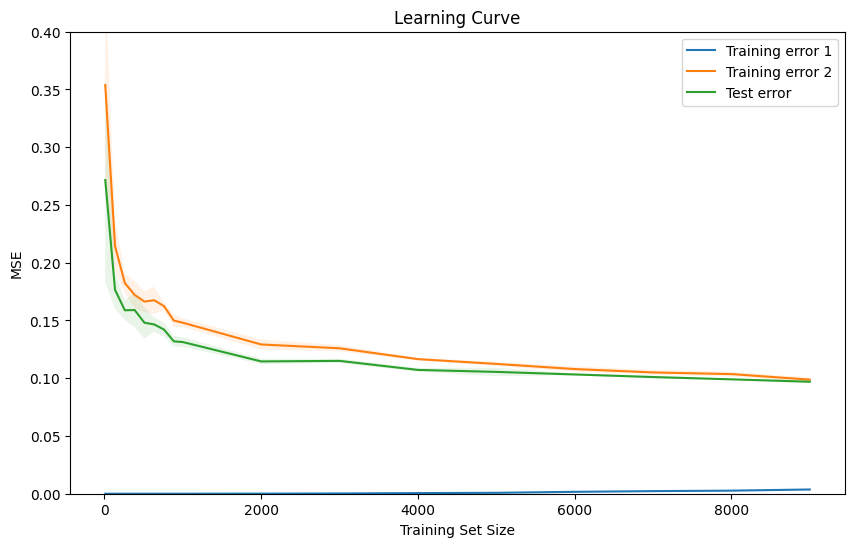

In [35]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train1_mean, label='Training error 1')
plt.plot(train_sizes, train2_mean, label='Training error 2')
plt.plot(train_sizes, test_mean, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([0.0, 0.40])
plt.show()

In [11]:
print(train_mean, train_std, test_mean, test_std)

[0.00000000e+00 2.14702190e-16 2.10826870e-16 4.55845133e-15
 7.77780409e-07 2.69708957e-05 3.81146905e-02 5.49393706e-02
 6.45275582e-02 6.51802651e-02 6.83914609e-02 6.85243081e-02
 7.12151742e-02 6.80887099e-02 6.42353502e-02 6.41943114e-02
 6.68044209e-02 6.84278883e-02 6.96860043e-02 7.22362140e-02] [0.00000000e+00 1.87456638e-18 5.48079409e-18 6.13572921e-15
 3.98679159e-07 2.61982122e-05 2.10927544e-03 5.50174316e-03
 1.73219011e-03 3.03818331e-03 1.53711792e-03 2.05788269e-03
 1.02808108e-03 4.33698388e-04 5.58471508e-04 7.39185021e-04
 6.67304172e-04 4.88120294e-04 3.36222368e-04 5.32103411e-04] [0.22476604 0.21984403 0.17999751 0.22562262 0.15456883 0.1556772
 0.10639668 0.09545906 0.08792098 0.08720874 0.08968134 0.08906839
 0.08394032 0.08229218 0.08252969 0.0813772  0.08166744 0.08276272
 0.0852662  0.07842087] [0.0101751  0.06617633 0.04482506 0.04732252 0.00761723 0.01452601
 0.00352707 0.00195306 0.00031663 0.00051078 0.00301702 0.00184991
 0.00367295 0.00121545 0.00208

## Unique Maps Seen

Unique trainig size: 1
Training error 1: 0.000000 ± 0.000000
Training error 2: 0.000003 ± 0.000002
Test error: 0.335602 ± 0.101633

Unique trainig size: 11
Training error 1: 0.000007 ± 0.000003
Training error 2: 0.002150 ± 0.001304
Test error: 0.180157 ± 0.035080

Unique trainig size: 21
Training error 1: 0.000062 ± 0.000020
Training error 2: 0.013710 ± 0.005357
Test error: 0.154258 ± 0.020446

Unique trainig size: 31
Training error 1: 0.000196 ± 0.000125
Training error 2: 0.016379 ± 0.003982
Test error: 0.127024 ± 0.008445

Unique trainig size: 41
Training error 1: 0.000145 ± 0.000090
Training error 2: 0.025308 ± 0.011191
Test error: 0.130402 ± 0.003451

Unique trainig size: 51
Training error 1: 0.000257 ± 0.000135
Training error 2: 0.029296 ± 0.001814
Test error: 0.127227 ± 0.003369

Unique trainig size: 61
Training error 1: 0.000198 ± 0.000059
Training error 2: 0.035764 ± 0.000999
Test error: 0.117281 ± 0.004498

Unique trainig size: 71
Training error 1: 0.000272 ± 0.000020
Training

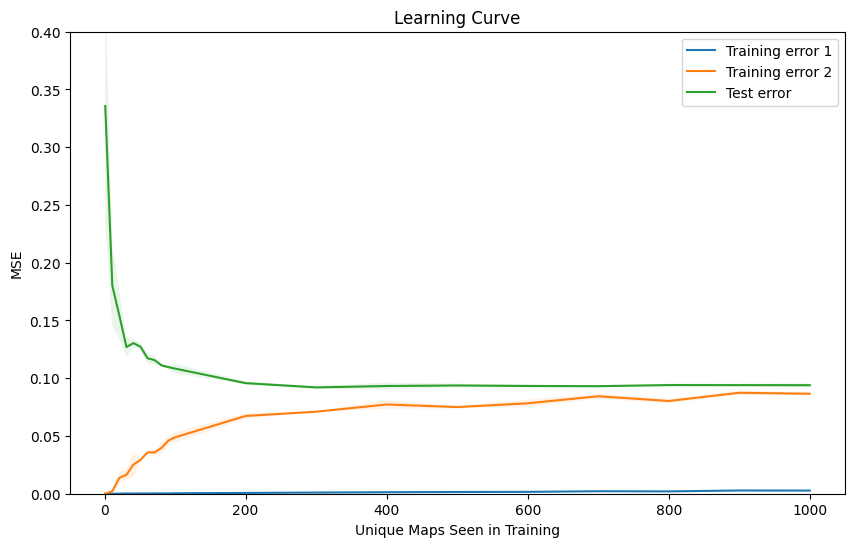

In [10]:
#Getting min and max number of simulations
sim_min = dataset['Simulations'].min()
sim_max = dataset['Simulations'].max()

#Features to be used in the model
features = ['Simulations']

#Unique maps
unique_maps = []
for map in dataset["Map"].unique():
    unique_maps.append(map)
map_count = len(unique_maps)

#Folds
fold = 3

# Train size
training_set_size = 10000

# Unique maps seen in training
unique_train_sizes = list(range(1, 101, 10)) + list(range(100, 1001, 100))
replacement = True

train_scores1 = []
train_scores2 = []
test_scores = []

for unique_train_size in  unique_train_sizes:
    train_scores1.append([])
    train_scores2.append([])
    test_scores.append([])
    
    for i in range(fold):
        #Creating Test Set
        
        train_maps = np.random.default_rng().choice(unique_maps, size=unique_train_size, replace=False)
        test_maps = np.setdiff1d(unique_maps, train_maps)
        #print("Total unique maps?: ", len(train_maps) + len(test_maps))
        test_set = dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        test_set_x = []
        test_set_y = []
        for j in range(len(test_set)):
            test_set_x.append([test_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(test_set.index[j][0]), padding)))
            test_set_y.append(test_set[j])

        #Creating Training Set
        training_set = dataset[dataset['Map'].isin(train_maps)]
        training_set_sampled = training_set.sample(n=training_set_size, replace=replacement)
        training_set_x = np.append(training_set_sampled["Simulations"].values.reshape(-1, 1), training_set_sampled['Encoded_Map'].apply(pd.Series).values, axis=1)
        training_set_y = training_set_sampled["Discounted Return"].values

        #print("Maps seen in training: %d" % (len(training_set["Map"].unique())))
        #Creating Training Score 1 Set - Looking only sampled points
        training_score1_set = training_set_sampled.groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score1_set_x = []
        training_score1_set_y = []
        for j in range(len(training_score1_set)):
            training_score1_set_x.append([training_score1_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(training_score1_set.index[j][0]), padding)))
            training_score1_set_y.append(training_score1_set[j])
            
        #Creating Training Score 2 Set - Looking all datapoints in the training sample
        training_sampled_unique = training_set_sampled["Map"].unique()
        training_score2_set = training_set[training_set["Map"].isin(training_sampled_unique)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score2_set_x = []
        training_score2_set_y = []
        for i in range(len(training_score2_set)):
            training_score2_set_x.append([training_score2_set.index[i][1]] + encode_maze(training_score2_set.index[i][0]))
            training_score2_set_y.append(training_score2_set[i])


        # print("train score set info: ")
        # a = (training_set.groupby(["Map", "Simulations"]).std()["Discounted Return"] / (training_set.groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(a.mean())
        # print("test set info: ")
        # b = (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).std()["Discounted Return"] / (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(b.mean())
        #Training
        for model_name, model in models.items():
            model.fit(training_set_x, training_set_y)
            
            #Predicting on test set
            y_pred = model.predict(test_set_x)
            test_score = mean_squared_error(test_set_y, y_pred)
            test_scores[-1].append(test_score)
            
            #Predicting on training score 1 set
            y_pred = model.predict(training_score1_set_x)
            train_score1 = mean_squared_error(training_score1_set_y, y_pred)
            train_scores1[-1].append(train_score1)
            
            #Predicting on training score 2 set
            y_pred = model.predict(training_score2_set_x)
            train_score2 = mean_squared_error(training_score2_set_y, y_pred)
            train_scores2[-1].append(train_score2)
            
        # print("Fold: %d\nTraining set size: %d\nTraining error: %f\nTest error: %f\n" % (i, training_set_size, train_score, test_score))
    print("Unique trainig size: %d\nTraining error 1: %f ± %f\nTraining error 2: %f ± %f\nTest error: %f ± %f\n" % (unique_train_size, np.mean(train_scores1[-1]), np.std(train_scores1[-1]), np.mean(train_scores2[-1]), np.std(train_scores2[-1]), np.mean(test_scores[-1]), np.std(test_scores[-1])))
        
# Calculate the mean and standard deviation of the training and test scores
train1_mean = np.mean(train_scores1, axis=1)
train1_std = np.std(train_scores1, axis=1)
train2_mean = np.mean(train_scores2, axis=1)
train2_std = np.std(train_scores2, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(unique_train_sizes, train1_mean, label='Training error 1')
plt.plot(unique_train_sizes, train2_mean, label='Training error 2')
plt.plot(unique_train_sizes, test_mean, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(unique_train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(unique_train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(unique_train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Unique Maps Seen in Training')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([0.0, 0.4])
plt.show()